In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

In [3]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

In [4]:
labels = pd.read_csv("content/eye_gender_data/Training_set.csv") 

In [5]:
file_paths = [[fname, 'content/eye_gender_data/train/' + fname] for fname in labels['filename']]

In [6]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])

In [7]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

In [27]:
X_train = []
y_train = []
image_size = 75
for i in range(len(train_data)):
    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    X_train.append(new_img_array)
    y_train.append(train_data['label'][i])

In [28]:
X_train=np.array(X_train)
y_train=np.array(y_train)

# labeling male as 1 and female as 0
y_train=np.where(y_train=="male",1,0)

In [29]:
# reshape for feeding into the model
X_train = X_train.reshape(X_train.shape[0], 75, 75, 1)

print('\nX_train.shape: {}, of {}'.format(X_train.shape, X_train.dtype))


X_train.shape: (9220, 75, 75, 1), of uint8


In [30]:
# define input shape
INPUT_SHAPE = (75, 75, 1)

# define sequential model
model = tf.keras.models.Sequential()

#define rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/1, input_shape=(75,75, 1)))

# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 75, 75, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10368)            

In [31]:
EPOCHS = 20
X_train_scaled = X_train / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)


In [33]:
history = model.fit(X_train_scaled, y_train,
                    batch_size=200,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/20
42/42 [==============================] - 27s 380ms/step - loss: 0.6903 - accuracy: 0.5753 - val_loss: 0.5902 - val_accuracy: 0.7354
Epoch 2/20
42/42 [==============================] - 15s 364ms/step - loss: 0.4866 - accuracy: 0.7772 - val_loss: 0.4272 - val_accuracy: 0.8113
Epoch 3/20
42/42 [==============================] - 16s 383ms/step - loss: 0.3855 - accuracy: 0.8308 - val_loss: 0.3855 - val_accuracy: 0.8275
Epoch 4/20
42/42 [==============================] - 16s 372ms/step - loss: 0.3503 - accuracy: 0.8536 - val_loss: 0.3172 - val_accuracy: 0.8720
Epoch 5/20
42/42 [==============================] - 16s 372ms/step - loss: 0.3192 - accuracy: 0.8644 - val_loss: 0.3031 - val_accuracy: 0.8829
Epoch 6/20
42/42 [==============================] - 16s 372ms/step - loss: 0.2816 - accuracy: 0.8827 - val_loss: 0.2888 - val_accuracy: 0.8872
Epoch 7/20
42/42 [==============================] - 16s 371ms/step - loss: 0.2621 - accuracy: 0.8941 - val_loss: 0.2906 - val_accuracy: 0.8764

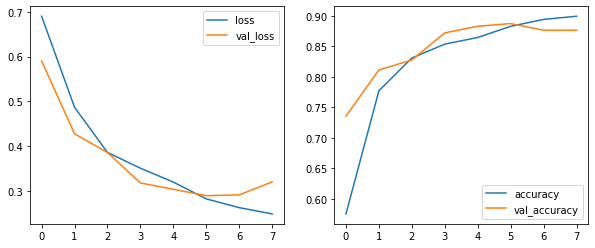

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [35]:
labels = pd.read_csv("content/eye_gender_data/Testing_set.csv")   # loading the labels
file_paths = [[fname, 'content/eye_gender_data/test/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_data = pd.merge(images, labels, how = 'inner', on = 'filename')

X_test = [] # initialize an empty numpy array
image_size = 75     # image size taken is 100 here. one can take other size too
for i in range(len(test_data)):
    img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    X_test.append(new_img_array)

In [36]:
X_test=np.array(X_test)
X_test.shape

(2305, 75, 75)

In [37]:
X_test = X_test / 255.

In [38]:
# reshape for feeding into the model
X_test = X_test.reshape(X_test.shape[0], 75, 75, 1)

print('\nX_test.shape: {}, of {}'.format(X_test.shape, X_test.dtype))


X_test.shape: (2305, 75, 75, 1), of float64


In [39]:
predictions = model.predict(X_test)
predictions[:5]

array([[0.00554953, 0.99445045],
       [0.1670588 , 0.8329412 ],
       [0.15343988, 0.8465601 ],
       [0.70000863, 0.29999137],
       [0.01446496, 0.985535  ]], dtype=float32)

In [40]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int64)

In [41]:
prediction_labels=np.where(prediction_labels==1,"male","female")

In [42]:
res = pd.DataFrame(prediction_labels)  
res.columns = ["label"]
res.to_csv("prediction_results_8.csv", index = False)